# main.ipynb

In this notebook, we walk through our methods for detecting the positions of darts on a dartboard, and returning a score based on their positions. We have a few different methods we tried to implement, and experimented with many ideas. 

In [4]:
# Imports

from shapely.geometry import Point, Polygon
import json
import psycopg2
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
from psycopg2 import sql
from scipy.ndimage import rotate
import cv2
import numpy as np
import sqlite3
import numpy as np
from scipy.ndimage import rotate
import io
import base64
from PIL import Image
import psycopg2
from PIL import Image
from io import BytesIO
import matplotlib.patches as patches

## Intial Implementation, Work Flow, and Thought Process

Our first goal was to figure out what was going to be the best way to capture a photo of the dartboard: such that we had enough information present to determine locations of darts, and where those darts were relative to the board. We first tried to do this with template matching and some geometry based on where they were located. 

We decided that we would try with some frontal images to start, as that would be easiest for the user in terms of capturing their throws. 

### Experimentation with Frontal View

In [5]:
# This function creates templates of the 20 and the 3 based on a hard-coded set of coordinates. It only needs to be ran
# one time, and you will need to adjust the coordinates based off of your input image.

# The idea is to get a clear image of the 20 and the 3 of your board such that you can locate it in future images. 
def create_template(image_path, output_20_path, output_3_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Format: (start_x, start_y, width, height)
    coords_20 = (2051,1864,70,70) 
    coords_3 = (2066,2635,50,60)

    # Crop the "20" number
    x, y, w, h = coords_20
    template_20 = image[y:y+h, x:x+w]
    cv2.imwrite(output_20_path, template_20)
    print(f"Template for '20' saved to {output_20_path}")

    # Crop the "3" number
    x, y, w, h = coords_3
    template_3 = image[y:y+h, x:x+w]
    cv2.imwrite(output_3_path, template_3)
    print(f"Template for '3' saved to {output_3_path}")

# Only need to do this once to get the intial templates
# create_template(
#     '../Sample Images/throw_1_1.JPG',
#     '../Templates/20_cropped.png',
#     '../Templates/3_cropped.png'
# )

Now, in the below code, we take in the image of our darts that were thrown.. an output path, and our two templates.

The result is a cropped image of the board.

The next step would be to get this in a workflow such that we are able to pull the most recently captured photo when a user saves a photo from the front end. For now, I am less worried about the logistics of that and more worried about quantifying the board for scoring.

One notable shortcoming of this method is that the template for the 20 and the 3 do not currently work for 20's and 3's at different scales. Therefore, if a user zoomed in and took their photo, the board would not be detected correctly. I tested this with the sample photos, and all the photos I took from where I threw the darts worked perfectly fine, despite me not being super careful about where I took the photo from.


In [6]:
def generate_scaled_templates(template, scales):
    scaled_templates = []
    for scale in scales:
        new_size = (int(template.shape[1] * scale), int(template.shape[0] * scale))
        scaled_template = cv2.resize(template, new_size, interpolation=cv2.INTER_LINEAR)
        scaled_templates.append(scaled_template)
    return scaled_templates

def detect_numbers_and_crop(image_path, output_path, template_20_path, template_3_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load templates for "20" and "3"
    template_20 = cv2.imread(template_20_path, cv2.IMREAD_GRAYSCALE)
    template_3 = cv2.imread(template_3_path, cv2.IMREAD_GRAYSCALE)

    # Generate scaled templates
    scales = [0.9 + 0.01 * i for i in range(-10, 11)]  # 10 smaller and 10 larger
    scaled_templates_20 = generate_scaled_templates(template_20, scales)
    scaled_templates_3 = generate_scaled_templates(template_3, scales)

    loc_20 = []
    loc_3 = []

    # Perform template matching for each scaled template
    for scaled_template in scaled_templates_20:
        res_20 = cv2.matchTemplate(gray, scaled_template, cv2.TM_CCOEFF_NORMED)
        threshold_20 = 0.8  
        loc_20_level = np.where(res_20 >= threshold_20)
        loc_20.extend(zip(loc_20_level[1], loc_20_level[0]))  # Store (x, y) coordinates

    for scaled_template in scaled_templates_3:
        res_3 = cv2.matchTemplate(gray, scaled_template, cv2.TM_CCOEFF_NORMED)
        threshold_3 = 0.8  # Adjust this threshold as needed
        loc_3_level = np.where(res_3 >= threshold_3)
        loc_3.extend(zip(loc_3_level[1], loc_3_level[0]))  # Store (x, y) coordinates

    if not loc_20 or not loc_3:
        print("Could not find both numbers on the dartboard.")
        return

    # Get the coordinates of the first detected numbers
    top_left_20 = loc_20[0]
    top_left_3 = loc_3[0]

    # Calculate the bottom-left corner of 3
    bottom_left_3 = (top_left_3[0], top_left_3[1] + template_3.shape[0])

    # Calculate the top-right corner of 20
    top_right_20 = (top_left_20[0] + template_20.shape[1], top_left_20[1])

    # Calculate the center and radius of the circle
    center_x = (bottom_left_3[0] + top_right_20[0]) // 2
    center_y = (bottom_left_3[1] + top_left_20[1]) // 2
    radius = int(np.linalg.norm(np.array(bottom_left_3) - np.array(top_right_20)) // 2)

    # Calculate the bounding box for cropping
    x1 = center_x - radius
    y1 = center_y - radius
    x2 = center_x + radius
    y2 = center_y + radius

    # Ensure the coordinates are within the image boundaries
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Show image
    plt.imshow(cropped_image)
    plt.title("Cropped Dartboard Region")
    plt.axis('off')
    plt.show()

    # Save the cropped image
    cv2.imwrite(output_path, cropped_image)

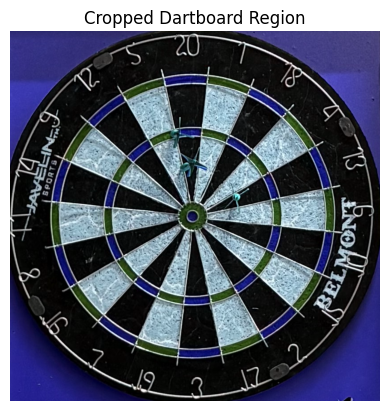

In [7]:
# Get the cropped dartboard of thrown darts
detect_numbers_and_crop(
    '../Sample Images/throw_5_1.JPG',
    '../Sample Images/thrown_dartboard.JPG',
    '../Templates/20_cropped.png',  # Path to "20" template
    '../Templates/3_cropped.png'    # Path to "3" template
)

Now, can we try to locate some darts here by comparing the differences found in images? If we compare the difference between a template image, and an image with darts thrown in it, shouldn't the largest areas of difference between the two images be the darts themselves?

In [8]:
def load_images(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded.")

    return img1, img2

def resize_images(img1, img2):
    # Resize img2 to match img1 if they are not the same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_AREA)
    return img1, img2

def rotate_image(image, angle):
    (h, w) = image.shape[:2]

    center = (w // 2, h // 2)
    
    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def calculate_mse(img1, img2):
    return np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)

def find_best_rotation(img1, img2, angle_range=(-10, 10), step=1):
    best_angle = 0
    min_mse = float('inf')
    best_rotated_img = img2

    # Iterate over the range of angles
    for angle in range(angle_range[0], angle_range[1] + 1, step):
        rotated_img = rotate_image(img2, angle)
        mse = calculate_mse(img1, rotated_img)

        if mse < min_mse:
            min_mse = mse
            best_angle = angle
            best_rotated_img = rotated_img

    return best_angle, best_rotated_img

def visualize_results(img1, img2, best_rotated_img, best_angle):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Best Rotated Image (Angle: {})'.format(best_angle))
    plt.imshow(cv2.cvtColor(best_rotated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Original Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

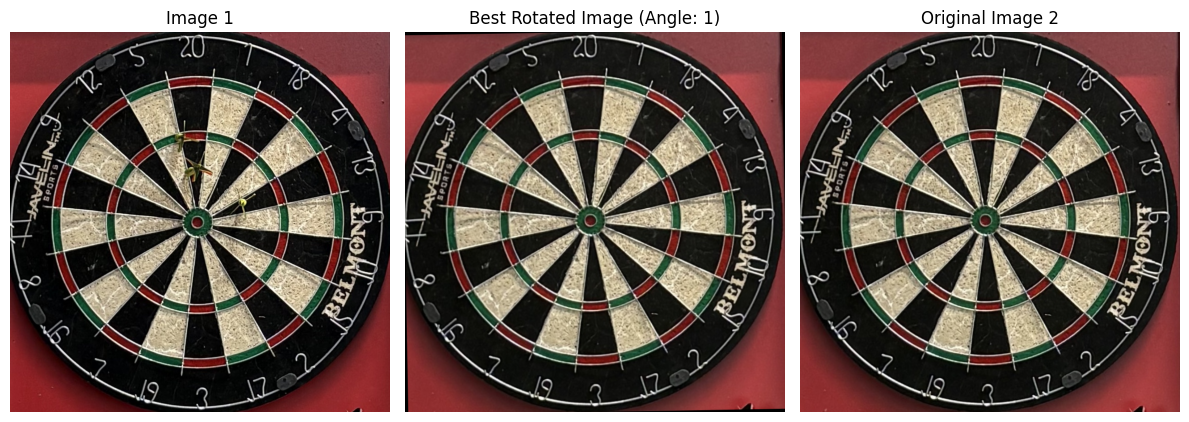

In [9]:
image_path1 = '../Sample Images/thrown_dartboard.JPG'
image_path2 = '../Sample Images/blank_dartboard_cropped.JPG'

img1, img2 = load_images(image_path1, image_path2)
img1, img2 = resize_images(img1, img2)
best_angle, best_rotated_img = find_best_rotation(img1, img2, angle_range=(-10, 10), step=1)

# Save the rotated image with "_rotated" appended to the filename
rotated_image_path = image_path2.replace('.JPG', '_rotated.JPG')
cv2.imwrite(rotated_image_path, best_rotated_img)

visualize_results(img1, img2, best_rotated_img, best_angle)

In [10]:
def load_images(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise ValueError("One of the images could not be loaded.")

    return img1, img2

def compare_images(img1, img2):
    # Check if images are identical
    if np.array_equal(img1, img2):
        print("The images are identical.")
        return None, []

    # Convert to HSV color space
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    # Apply Gaussian blur to smooth the images
    img1_blurred = cv2.GaussianBlur(img1_hsv, (5, 5), 0)
    img2_blurred = cv2.GaussianBlur(img2_hsv, (5, 5), 0)

    # Calculate the absolute difference in the processed images
    diff = cv2.absdiff(img1_blurred, img2_blurred)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Threshold the difference image
    _, thresh = cv2.threshold(diff_gray, 30, 255, cv2.THRESH_BINARY)

    # Find contours of the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    return diff, sorted_contours[:100]  # Return the top 100 contours

def visualize_differences(img1, img2, diff, contours):
    img1_copy = img1.copy()

    # Draw rectangles around the top 100 contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img1_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference Image')
    plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

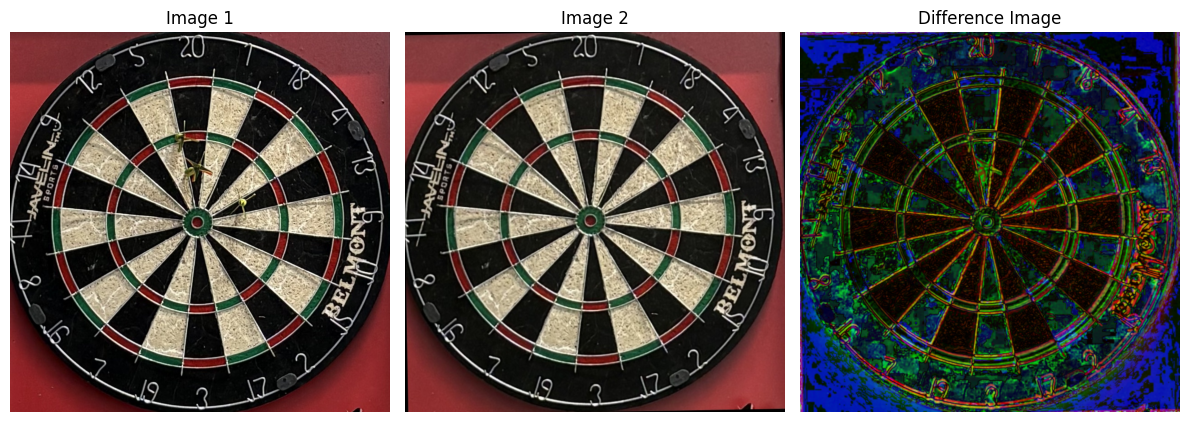

In [11]:
image_path1 = '../Sample Images/thrown_dartboard.JPG'
image_path2 = '../Sample Images/blank_dartboard_cropped_rotated.JPG'

img1, img2 = load_images(image_path1, image_path2)
img1, img2 = resize_images(img1, img2)  # Ensure both images are the same size
diff, contours = compare_images(img1, img2)

if diff is not None:
    visualize_differences(img1, img2, diff, contours)

In [12]:
def visualize_differences(img1, img2, top_blocks):
    img1_copy = img1.copy()

    # Draw rectangles around the top 3 blocks with the highest SSD
    for _, (x, y) in top_blocks:
        cv2.rectangle(img1_copy, (x, y), (x + 50, y + 50), (0, 255, 0), 2)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Top 3 SSD Areas Highlighted')
    plt.imshow(cv2.cvtColor(img1_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
def calculate_ssd_blocks(img1, img2, block_size=50, margin=100):
    height, width = img1.shape[:2]
    ssd_values = []

    # Define the search area limits
    y_start = margin
    y_end = height - margin
    x_start = margin
    x_end = width - margin

    # Iterate through the image in blocks within the defined limits
    for y in range(y_start, y_end - block_size + 1, block_size):
        for x in range(x_start, x_end - block_size + 1, block_size):
            block1 = img1[y:y + block_size, x:x + block_size]
            block2 = img2[y:y + block_size, x:x + block_size]
            ssd = np.sum((block1.astype(np.float32) - block2.astype(np.float32)) ** 2)
            ssd_values.append((ssd, (x, y)))

    # Sort by SSD and return the top 3
    ssd_values.sort(reverse=True, key=lambda x: x[0])
    return ssd_values[:3]

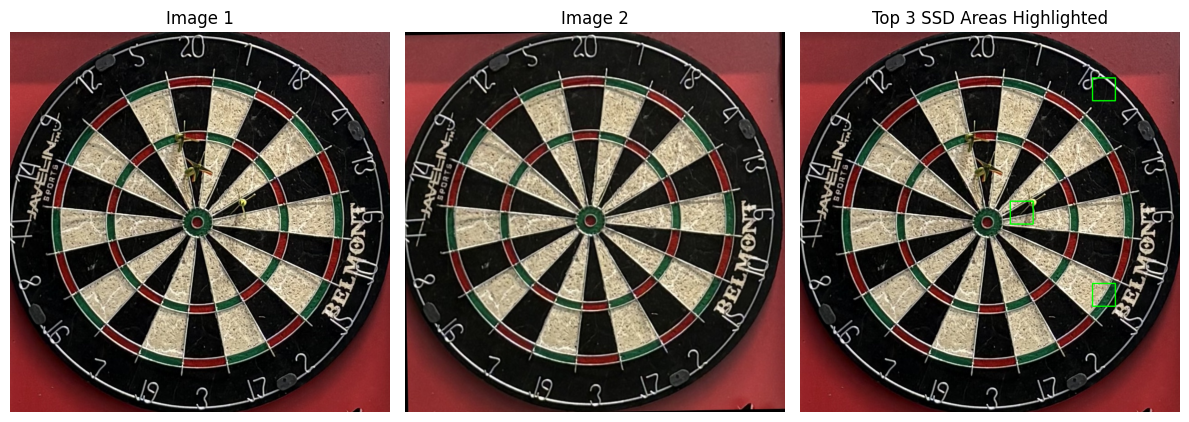

In [13]:
image_path1 = '../Sample Images/thrown_dartboard.JPG'
image_path2 = '../Sample Images/blank_dartboard_cropped_rotated.JPG'

img1, img2 = load_images(image_path1, image_path2)
img1, img2 = resize_images(img1, img2)  # Ensure both images are the same size
top_blocks = calculate_ssd_blocks(img1, img2, block_size=90, margin=100)

visualize_differences(img1, img2, top_blocks)

So, even after rotating the template photo to match the dart photo - you can see the results of locating difference patches between the two images is not very accurate. 

As you can see, the takeway here is that while locating the board and cropping it based on the image is definitley possible using only a image captured from the front, there is just simply not good enough of an angle to see actual tips from this view. 

Trying this out, we had a new idea: what if we could take a photo from the side of the board, and then use AruCo markings to compute a homography resulting in what would appear to still be a frontal image? This would give us the best of both worlds: the information gained by looking at the throws from the side, but also a frontal view that allows us to standardize our scoring (getting the same photo each time (theoretically) with the center of the board at the center of the resulting image). 

### Computing a Homography Based on a Side Image and ArUco Markings

In [14]:
# code here of computing homography

So, now we have a method of getting a standardized photo each time from the user. It is now time to try to attempt to locate the darts. We tried a few methods.

### Dart Tip Detection

In [15]:
# show all methods we tried.. ending with the best method (neon yellow mask, yellow darts, finding countours, and taking the farthest right pointBased

Great - at this point we can reliably detect the location of the tip of the dart on the board, and relate that to coordinates in the image. How can we turn that into a score based on the regions of the dartboard?

### Converting Coordinates to Score

In [16]:
# show the code with the coco json stuff, returning score from coordinates

## Extensions and Improvements

- how can we find regions of the dartboard without a manually generated mapping? If we want this to be able to work well on any dart board, we cannot assume that ArUco's will get us the same homography every time.. we need something more robust which can look at the image and find regions (enter Rachel's ideas and code + some of reed's)
- How can we detect darts without the need for spray painting them neon yellow? (enter Jonathan's work with ML)

### Detecting Dartboard Regions without Manual Mapping

This method will detect the different scoring regions of the dartboard by color detection instead of a manual mapping. After creating the scoring map for the board, scores can be assigned by comparing the detected dart "hit" locations to the scoring map. The image displayed shows the different scoring rings detected by this method. Each of these rings is divided into sectors to isolate each score.

In [20]:
def fill_mask(mask, radius, iter):
    # Fills in gaps in a binary color mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radius, radius))  
    mask_uint8 = mask.astype(np.uint8) * 255
    closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel, iterations=iter)
    return closed > 0

In [21]:
img = cv2.cvtColor(cv2.imread("../../Sample Images/aruco_result_blank.jpg"), cv2.COLOR_BGR2RGB)
detected_img = img.copy()
detected_img = (detected_img/2).astype(int)

height, width, colors = img.shape
h_center = int(height/2)
w_center = int(width/2)

# Dart board scores in clockwise order
sector_scores = [20, 1, 18, 4, 13, 6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5]

# Angles for detecting scores
Y, X = np.ogrid[:height, :width]
dy = h_center - Y
dx = X - w_center
angles = np.arctan2(dy, dx)
angles = np.degrees(angles)
angles = (angles + 360) % 360 
angles = (90 - angles) % 360
sector_map = np.floor(angles / 18).astype(int)
score_map = np.array(sector_scores)[sector_map]

# Array for storing the score associated with each pixel in the image
scores = np.zeros((height, width))

# Color averages for region detection
red_avg = np.mean(img[:,:,0])
green_avg = np.mean(img[:,:,1])
blue_avg = np.mean(img[:,:,2])

# Locate bullseye region
radius = 75
bullseye_mask = (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,0] > red_avg) &\
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,1] < green_avg) &\
           (img[h_center-radius:h_center+radius, w_center-radius:w_center+radius,2] < blue_avg)
# Fill in gaps in mask
bullseye_mask = fill_mask(bullseye_mask, 11, 3)
detected_img[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = [255,0,0]
scores[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = 50

# Update center with better estimate from bullseye
bullseye_mask_binary = np.zeros((img.shape[0],img.shape[1]))
bullseye_mask_binary[h_center-radius:h_center+radius, w_center-radius:w_center+radius][bullseye_mask] = 1
M = cv.moments(bullseye_mask_binary)
if M["m00"] != 0:
    h_center = int(M["m01"] / M["m00"])
    w_center = int(M["m10"] / M["m00"])
Y,X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((Y-h_center)**2 + (X-w_center)**2)

# Locate inner green circle
radius = 75
green_circle_mask = (dist_from_center <= radius) & \
                    (img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)
green_circle_mask = fill_mask(green_circle_mask, 11, 3)
detected_img[green_circle_mask] = [0,255,0]
scores[green_circle_mask] = 25

# Locate inner red/green circle
radius = 500
inner_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 350) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] < blue_avg)))
inner_circle_mask = fill_mask(inner_circle_mask, 11, 5)
detected_img[inner_circle_mask] = [255,100,0]
scores[inner_circle_mask] = score_map[inner_circle_mask] * 3

# Locate white/black regions
radius = 675
white_black_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 75) &\
                    (((img[:,:,0] < red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] > red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] > blue_avg)))
white_black_circle_mask = fill_mask(white_black_circle_mask, 2, 1)
detected_img[white_black_circle_mask]= 255
scores[white_black_circle_mask] = score_map[white_black_circle_mask]

# Locate outer red/green circle
radius = 750
outer_circle_mask = (dist_from_center <= radius) & (dist_from_center >= 500) &\
                    (((img[:,:,0] > red_avg) & (img[:,:,1] < green_avg) & (img[:,:,2] < blue_avg)) | \
                     ((img[:,:,0] < red_avg) & (img[:,:,1] > green_avg) & (img[:,:,2] < blue_avg)))
outer_circle_mask = fill_mask(outer_circle_mask, 5, 5)
detected_img[outer_circle_mask] = [255,0,100]
scores[outer_circle_mask] = score_map[outer_circle_mask] * 2

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Warped Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(detected_img)
plt.title("Warped Image with Detected Regions")
plt.axis('off')

plt.tight_layout()
plt.show()

[ WARN:0@70162.540] global loadsave.cpp:268 findDecoder imread_('../../Sample Images/aruco_result_blank.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Placing Jack's stuff here - we can find the best location for it once we format this section:

In [ ]:
%pip install opencv-python
%pip install os
%pip install numpy
%pip install segment_anything
%pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

import os
import cv2
import numpy as np
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 43.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://download.

In [ ]:
def get_mask_for_point(image_path, point, model_type="default", checkpoint_path=None):
    try:
        # Load SAM model
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found at: {checkpoint_path}")
        sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
        predictor = SamPredictor(sam)

        # Load/set img
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image)

        # Generate mask
        input_point = np.array([point])
        input_label = np.array([1])  # For foreground
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,  # Return only the best mask
        )
        return masks[0]  # Return the first mask (best mask)

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
# Example usage
image_path = "test.jpg"
checkpoint_path_small = "sam_vit_b_01ec64.pth"
point = (1000, 1000) 

mask = get_mask_for_point(image_path, point, model_type="vit_b", checkpoint_path=checkpoint_path_small)

if mask is not None:
    print("Mask shape:", mask.shape)
    # You can further process or display the mask here.  For example:
    import matplotlib.pyplot as plt
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(image)
    plt.imshow(mask, cmap='gray', alpha=0.5)  # Overlay the mask
    plt.scatter(point[0], point[1], c='red', s=10) # added line
    plt.title('Image with Mask Overlay')
    plt.show()

else: print("Failed to generate mask.")

Error: Checkpoint file not found at: sam_vit_b_01ec64.pth
Failed to generate mask.
